# Resnet Exploration

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchinfo import summary
from tqdm import tqdm
import matplotlib.pyplot as plt

import time
import os
import copy

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = None

print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)
print("Pytorch device: ", device)


/Users/marakim/opt/anaconda3/envs/network_inflation/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/marakim/opt/anaconda3/envs/network_inflation/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.8.dylib
  Referenced from: <BE0CCD9A-269A-30E2-A23C-DA45E89EBB1F> /Users/marakim/opt/anaconda3/envs/network_inflation/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/marakim/opt/anaconda3/envs/network_inflation/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/Users/marakim/opt/anaconda3/envs/network_inflation/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/Users/marakim/opt/anaconda3/envs/network_inflation/lib/python3.10/lib-dynload/../../libjpeg.8.dylib' (no such file), '/Users/marakim/opt/anaconda3/envs/network_inflation/bin/../lib/libjpeg.8.dylib' (no such file), '/System/Vol

PyTorch Version:  1.13.1
Torchvision Version:  0.14.1a0
Pytorch device:  mps


In [3]:
from torchvision.models import resnet

resnet18 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', weights=resnet.ResNet18_Weights.IMAGENET1K_V1)
resnet34 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', weights=resnet.ResNet34_Weights.IMAGENET1K_V1)
resnet50 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', weights=resnet.ResNet50_Weights.IMAGENET1K_V1)
resnet101 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', weights=resnet.ResNet101_Weights.IMAGENET1K_V1)
resnet152 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', weights=resnet.ResNet152_Weights.IMAGENET1K_V1)

Using cache found in /Users/marakim/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /Users/marakim/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /Users/marakim/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /Users/marakim/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /Users/marakim/.cache/torch/hub/pytorch_vision_v0.10.0


In [4]:
resnets = [
    resnet18,
    resnet34,
    resnet50,
    resnet101,
    resnet152,
]

In [5]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
# training_data = torchvision.datasets.ImageNet('~/Documents/research/imagenet/', split="train", transform=preprocess)
training_data = torchvision.datasets.ImageFolder('~/Documents/research/imagenet/ILSVRC/Data/CLS-LOC/train/', transform=preprocess)

In [6]:
def train_model(model, data, batch_size=256, num_epochs=10):
    data_loader = torch.utils.data.DataLoader2(
        data,
        batch_size=batch_size,
        num_workers=4,
        shuffle=True,
    )

    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.AdamW(model.parameters())

    model.train()

    model.to(device)
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for inputs, labels in tqdm(data_loader):
            optimizer.zero_grad()
            outputs = model(inputs.to(device))
            loss = criterion(outputs, labels.to(device))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f'[epoch {epoch}]: loss: {epoch_loss}')

In [11]:
def eval_model(model, data, batch_size=256):
    data_loader = torch.utils.data.DataLoader2(
        data,
        batch_size=batch_size,
        num_workers=4,
    )

    model.eval()

    with torch.no_grad():
        model.to(device)
        correct = torch.Tensor(0).to(device)
        total = len(data_loader)
        for inputs, labels in tqdm(data_loader):
            outputs = model(inputs.to(device))
            correct += (outputs.max(dim=1).indices == labels.to(device)).sum()
        print(correct / total)

In [ ]:
eval_model(resnet152, training_data)

In [13]:
train_model(resnet152, training_data)

  0%|          | 25/5005 [04:28<14:51:50, 10.74s/it]


KeyboardInterrupt: 

In [ ]:
list(map(
    lambda x: x.eval(),
    resnets
))
"Eval mode"

In [ ]:
image = next(iter(training_data))
input_tensor = preprocess(image['image'])
input_tensor.shape

In [ ]:
summary(resnet18, [1, *input_tensor.shape])

In [32]:
list(map(
    lambda x: x.conv1,
    resnets
))

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)]

In [33]:
def cosine_similarity(weight0, weight1):
    cos = nn.functional.cosine_similarity
    return torch.stack(tuple(
        cos(
            weight0[idx].expand(weight1.shape),
            weight1,
        )
        for idx in range(weight0.shape[0])
    ))


def histogram(input, bins=100, range=(0,1), width=1):
    histogram = input.histogram(bins=bins,range=range)
    plt.bar(
        x=histogram.bin_edges[:-1].detach(),
        height=histogram.hist.detach(),
        width=width*(range[1]-range[0])/bins,
        align='edge')

def random_unit(shape):
    return torch.normal(torch.zeros(shape), torch.ones(shape))

def self_similarity(network0):
    weight0 = network0.conv1.get_parameter('weight').flatten(start_dim=1)
    measure = cosine_similarity(weight0, weight0).fill_diagonal_(0).abs().max(dim=1).values
    histogram(measure)

def similarity(network0, network1):
    measure = cosine_similarity(
        network0.conv1.get_parameter('weight').flatten(start_dim=1),
        network1.conv1.get_parameter('weight').flatten(start_dim=1),
    ).abs().max(dim=1).values
    histogram(measure)

def null_similarity(network0):
    weight0 = network0.conv1.get_parameter('weight').flatten(start_dim=1)
    measure = torch.stack([
        cosine_similarity(
            weight0,
            random_unit(weight0.shape)
        ).abs().max(dim=1).values
        for _ in range(2048)
    ])
    histogram(measure, bins=1000)


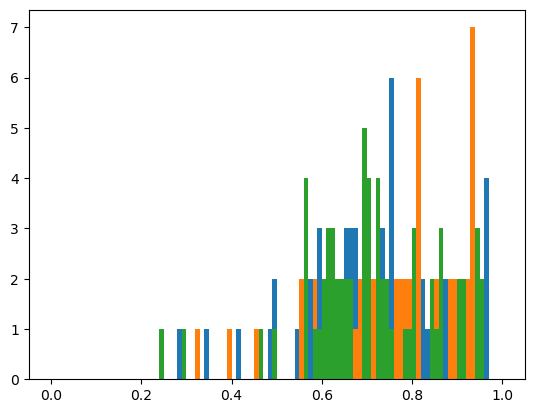

In [40]:
self_similarity(resnet50)
self_similarity(resnet101)
self_similarity(resnet152)

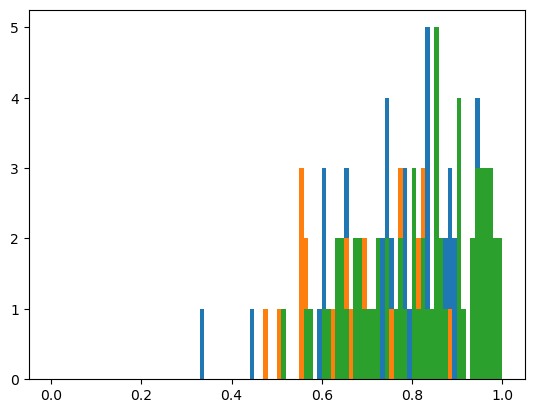

In [38]:
similarity(resnet50, resnet152)

similarity(resnet101, resnet152)

similarity(resnet152, resnet101)

KeyboardInterrupt: 

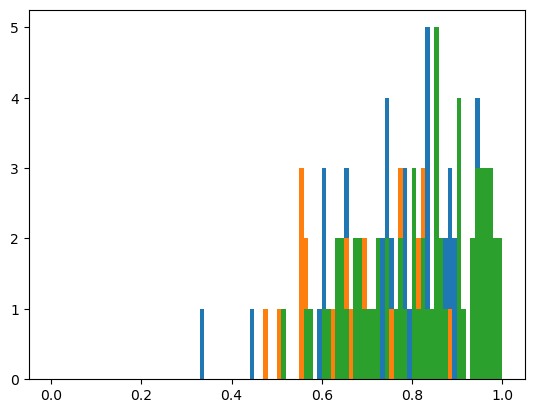

In [37]:
null_similarity(resnet152)

[x for x,_ in resnet50.named_parameters()]